## Imports

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import datetime
import squarify

sns.set(style="whitegrid")
%matplotlib inline

In [60]:
#bom_df = pd.read_csv('Data/bom.movie_gross.csv')
# imdb_name_df = pd.read_csv('Data/imdb.name.basics.csv')
# imdb_akas_df = pd.read_csv('Data/imdb.title.akas.csv')
# imdb_basics_df = pd.read_csv('Data/imdb.title.basics.csv')
# imbd_crew_df = pd.read_csv('Data/imdb.title.crew.csv')
# imdb_principals_df = pd.read_csv('Data/imdb.title.principals.csv')
# imdb_ratings_df = pd.read_csv('Data/imdb.title.ratings.csv')
# rt_info_df = pd.read_csv('Data/rt.movie_info.tsv', sep = '\t')
# rt_reviews_df = pd.read_csv('Data/rt.reviews.tsv', sep = '\t', encoding ='ISO-8859-1')
# tmdb_movies_df = pd.read_csv('Data/tmdb.movies.csv')
# tn_budgets_df = pd.read_csv('Data/tn.movie_budgets.csv')

tmdb_data = pd.read_csv('Data/tmdb_movies_data.csv')
oscars_data = pd.read_csv('Data/oscars_database.csv')

## Data Cleaning

#### Oscars Cleaning

In [61]:
oscars_data['Year'] = oscars_data['Year'].str[:4].astype('int64')
oscars_data = oscars_data[oscars_data['Year'] >= 2000]
oscars_data = oscars_data[oscars_data['Year'] <= 2019]
oscars_data.drop(columns = 'Ceremony', inplace = True)

In [62]:
oscars_data.isna().sum()

Year         0
Award        0
Winner    1458
Name         0
Film        72
dtype: int64

In [63]:
oscars_data = oscars_data[~oscars_data['Film'].isna()]
oscars_data = oscars_data.fillna(0)
oscars_data = oscars_data.set_index('Film')
oscars_data.sort_values('Film', inplace = True)

In [64]:
wins = oscars_data.groupby('Film').sum()['Winner']
nominations = oscars_data.groupby('Film').count()['Winner']

In [65]:
nominations.head()

Film
12 Years a Slave    3
127 Hours           1
21 Grams            2
45 Years            1
A Beautiful Mind    2
Name: Winner, dtype: int64

#### TMDB Cleaning

In [66]:
tmdb_data.columns

Index(['id', 'imdb_id', 'popularity', 'budget', 'revenue', 'original_title',
       'cast', 'homepage', 'director', 'tagline', 'keywords', 'overview',
       'runtime', 'genres', 'production_companies', 'release_date',
       'vote_count', 'vote_average', 'release_year', 'budget_adj',
       'revenue_adj'],
      dtype='object')

In [67]:
tmdb_data.drop(columns = ['id', 'homepage', 'tagline', 'keywords', 'overview', 'runtime', 'production_companies', 
                         'release_date'], inplace = True)

In [68]:
tmdb_data['cast'] = tmdb_data['cast'].apply(lambda x: str(x).split('|'))
tmdb_data['genres'] = tmdb_data['genres'].apply(lambda x: str(x).split('|'))
tmdb_data['budget'] = tmdb_data['budget']/1000000
tmdb_data['revenue'] = tmdb_data['revenue']/1000000

In [69]:
tmdb_cleaned = tmdb_data.sort_values(by = ['revenue_adj'], ascending = False)
tmdb_cleaned = tmdb_cleaned[~tmdb_cleaned.director.isna()]
tmdb_cleaned = tmdb_cleaned.drop_duplicates(subset ="imdb_id", keep = False)
tmdb_cleaned = tmdb_cleaned[tmdb_cleaned['release_year'] >= 2000]

tmdb_cleaned['budget_adj'] = tmdb_cleaned['budget_adj']/1000000
tmdb_cleaned['revenue_adj'] = tmdb_cleaned['revenue_adj']/1000000
tmdb_cleaned['profit'] = tmdb_cleaned['revenue_adj'] - tmdb_cleaned['budget_adj']

In [70]:
tmdb_cleaned[tmdb_cleaned['original_title'] == 'Avatar']

,imdb_id,popularity,budget,revenue,original_title,cast,director,genres,vote_count,vote_average,release_year,budget_adj,revenue_adj,profit
1386,tt0499549,9.432768,237.0,2781.505847,Avatar,"[Sam Worthington, Zoe Saldana, Sigourney Weave...",James Cameron,"[Action, Adventure, Fantasy, Science Fiction]",8458,7.1,2009,240.886903,2827.12375,2586.236847


#### Merging Data Frames

In [71]:
merged_data = tmdb_cleaned

In [72]:
merged_data = merged_data.merge(nominations, left_on = 'original_title', right_on = 'Film', how = 'left')
merged_data.rename(columns = {'Winner': 'nominations'}, inplace = True)
merged_data = merged_data.merge(wins, left_on = 'original_title', right_on = 'Film', how = 'left')
merged_data.rename(columns = {'Winner': 'wins'}, inplace = True)
#merged_data.nominations.fillna(0, inplace = True)
#merged_data.wins.fillna(0, inplace = True)

quick note! we want to do a left merge here, because if we do only the intersection, we will get a small selection of movies that have been nominated to the oscars meaning the budgets and revenues will be much much higher!

## Feature Generation (Genres)

In [73]:
comedies = merged_data[merged_data['genres'].apply(lambda x: 'Comedy' in x)]
dramas = merged_data[merged_data['genres'].apply(lambda x: 'Drama' in x)]
horrors = merged_data[merged_data['genres'].apply(lambda x: 'Horror' in x)]
adventures = merged_data[merged_data['genres'].apply(lambda x: 'Adventure' in x)]
fantasies = merged_data[merged_data['genres'].apply(lambda x: 'Fantasy' in x)]
thrillers = merged_data[merged_data['genres'].apply(lambda x: 'Thriller' in x)]
science_fictions = merged_data[merged_data['genres'].apply(lambda x: 'Science Fiction' in x)]
actions = merged_data[merged_data['genres'].apply(lambda x: 'Action' in x)]
crimes = merged_data[merged_data['genres'].apply(lambda x: 'Crime' in x)]
families = merged_data[merged_data['genres'].apply(lambda x: 'Family' in x)]
animations = merged_data[merged_data['genres'].apply(lambda x: 'Animation' in x)]
mysteries = merged_data[merged_data['genres'].apply(lambda x: 'Mystery' in x)]

In [74]:
genres = [comedies, dramas, horrors, adventures, fantasies, thrillers, science_fictions, actions, crimes, families, animations, mysteries]
genres_names = ['comedy', 'drama', 'horror', 'adventure', 'fantasy', 'thriller', 'science fiction', 'action', 'crime', 'family', 'animation', 'mystery']

In [75]:
revenues_adj_mean = []
budget_adj_mean = []
oscar_nominations = []
oscar_wins = []
for genre in genres:
    revenues_adj_mean.append(genre.mean()['revenue_adj'])
    budget_adj_mean.append(genre.mean()['budget_adj'])
    oscar_nominations.append(genre.sum()['nominations'])
    oscar_wins.append(genre.sum()['wins'])

to_df = []
for i in range(len(genres_names)):
    my_list = [genres_names[i], budget_adj_mean[i], revenues_adj_mean[i], oscar_nominations[i], oscar_wins[i]]
    to_df.append(my_list)

genres_df = pd.DataFrame(to_df, columns = ['genre', 'budget', 'revenue', 'oscar_nominations', 'oscar_wins']) 

In [76]:
genres_df.sort_values(by = ['revenue'], inplace = True, ascending = False)
genres_df['profit'] = genres_df['revenue'] - genres_df['budget']

In [77]:
genres_df = genres_df.reset_index().drop(columns = ['index'])
genres_df.head()

,genre,budget,revenue,oscar_nominations,oscar_wins,profit
0,adventure,52.896315,153.355885,14.0,2.0,100.459571
1,fantasy,46.038945,138.644258,7.0,0.0,92.605313
2,family,31.958533,95.348340,1.0,0.0,63.389808
3,action,36.729493,91.910526,22.0,5.0,55.181033
4,science fiction,32.986638,88.752090,3.0,0.0,55.765451


## Analysis & Visualizations (Genres)

Text(0,0.5,'Mean Revenue in Millions of Dollars')

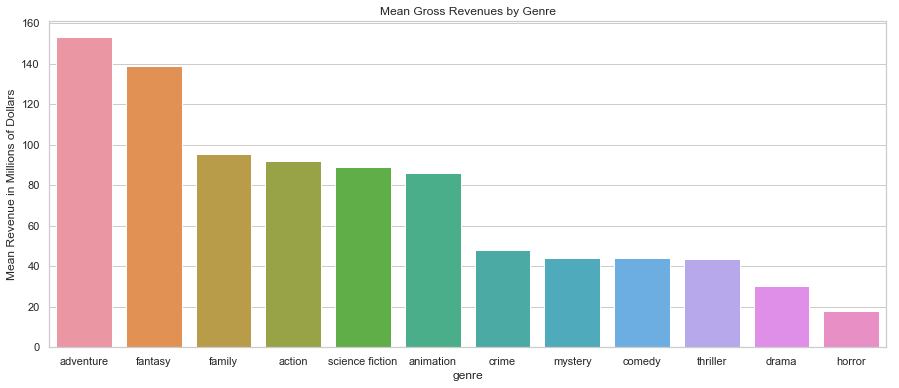

In [78]:
plt.figure(figsize = (15,6))
sns.barplot(x = 'genre', y = 'revenue', data = genres_df)
plt.title('Mean Gross Revenues by Genre')
plt.ylabel('Mean Revenue in Millions of Dollars')

Text(0,0.5,'Mean Profit in Millions of Dollars')

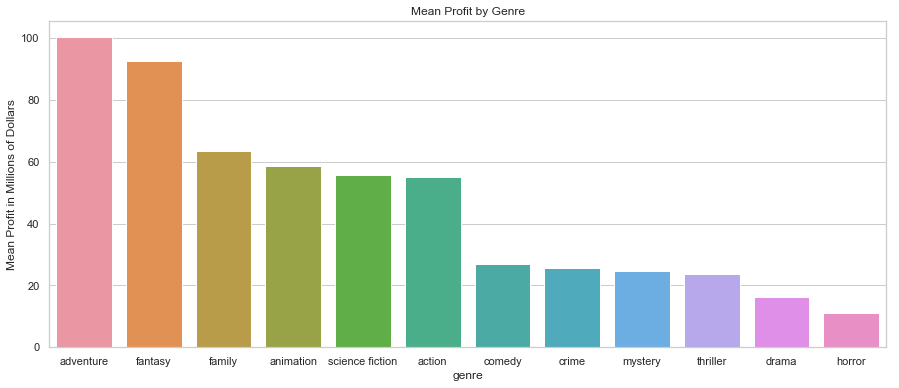

In [79]:
genres_df.sort_values(by = ['profit'], inplace = True, ascending = False)
plt.figure(figsize = (15,6))
sns.barplot(x = 'genre', y = 'profit', data = genres_df)
plt.title('Mean Profit by Genre')
plt.ylabel('Mean Profit in Millions of Dollars')

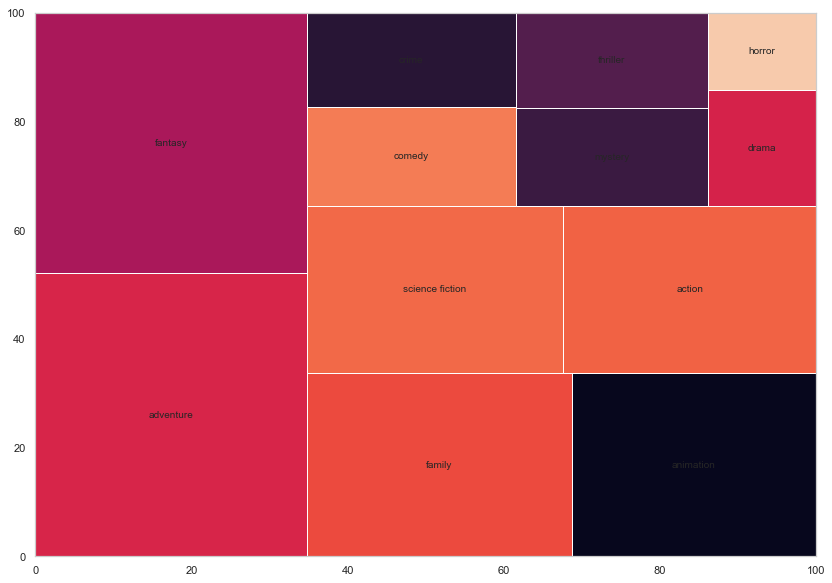

In [80]:
plt.figure(figsize = (14,10))
squarify.plot(sizes = genres_df['profit'], label = genres_df['genre'])

#### So it looks like we should go for adventure/fantasy, right? BUT WAIT! Microsoft wants a good film. It has a bunch of streaming content ready to go. Microsoft believes that the first film needs to make waves and gain attention for the platform, so we definitely want an oscar nod.

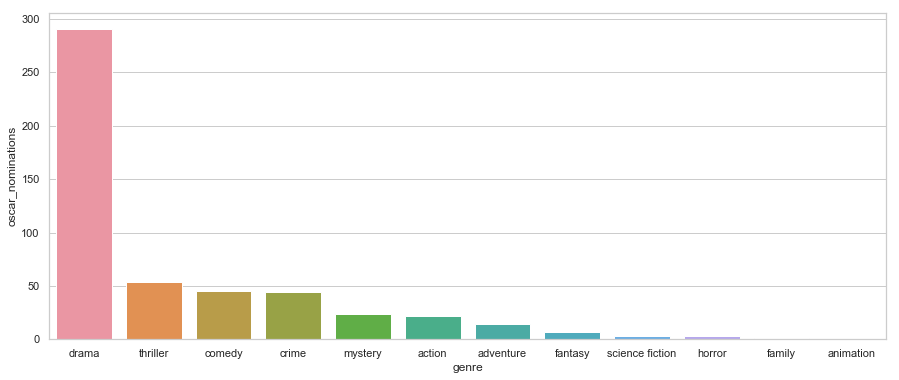

In [81]:
genres_df.sort_values(by = ['oscar_nominations'], ascending = False, inplace = True)
plt.figure(figsize = (15,6))
sns.barplot(x = 'genre', y = 'oscar_nominations', data = genres_df)
# add labels
# can I stack wins?


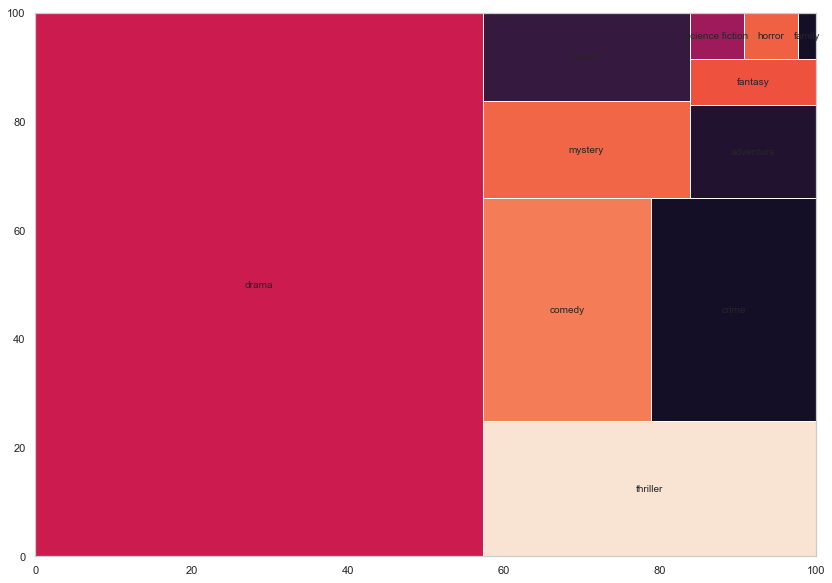

In [83]:
plt.figure(figsize = (14,10))
genres_df2 = genres_df[genres_df['oscar_nominations'] > 0]
squarify.plot(sizes = genres_df2['oscar_nominations'], label = genres_df2['genre'])

note! The above is actually counting multiple nominations (should we do it just if nominated?). This is probably ok, though.

New Question! Maybe we can combine genres.
Are there **drama/adventure**, **drama/fantasy**, **drama/comedy** films?
Note...remember to sort by highest grossing.

In [ ]:
drama_adventure = tmdb_cleaned[tmdb_cleaned['genres'].apply(lambda x: ('Drama' in x) & ('Adventure' in x))]
drama_fantasy = tmdb_cleaned[tmdb_cleaned['genres'].apply(lambda x: ('Drama' in x) & ('Fantasy' in x))]
drama_comedy = tmdb_cleaned[tmdb_cleaned['genres'].apply(lambda x: ('Drama' in x) & ('Comedy' in x))]

In [ ]:
drama_adventure = drama_adventure.sort_values(by = ['revenue_adj'], ascending = False)
drama_fantasy = drama_fantasy.sort_values(by = ['revenue_adj'], ascending = False)
drama_comedy = drama_comedy.sort_values(by = ['revenue_adj'], ascending = False)

We could try exploring this data ^ by profit rather than revenue, too

In [ ]:
drama_adventure.head(15)['original_title']

In [ ]:
drama_fantasy.head(15)['original_title']

In [ ]:
drama_comedy.head(15)['original_title']

In [ ]:
drama_adventure_oscars = drama_adventure.merge(nominations, left_on = 'original_title', right_on = 'Film', how = 'inner')
drama_fantasy_oscars = drama_fantasy.merge(nominations, left_on = 'original_title', right_on = 'Film', how = 'inner')
drama_comedy_oscars = drama_comedy.merge(nominations, left_on = 'original_title', right_on = 'Film', how = 'inner')

In [ ]:
drama_adventure_oscars.head(15)['original_title']

In [ ]:
drama_fantasy_oscars.head(15)['original_title']

In [ ]:
drama_comedy_oscars.head(10)['original_title']

In [ ]:
print(len(drama_adventure_oscars['original_title']))
print(len(drama_fantasy_oscars['original_title']))
print(len(drama_comedy_oscars['original_title']))

## Microsoft -- make a drama/comedy! It's the sweet spot between making bank and oscar nods!
Great ones to model include Juno, The Wolf of Wall Street, The Devil Wears Prada, Silver Linings Playbook. All of these were very high grossing films that also got oscar nominations.

#### Microsoft -- as a close second choice, make a drama/adventure film!
Great ones to model include Gladiator, The Martian, Cast Away, True Grit, Into the Wild, 127 Hours, and Cast Away. All of these were very high grossing films that also got oscar nominations.

## Now we have to figure out who should direct and write the film (given a drama/comedy)

In [ ]:
directors = drama_comedy[drama_comedy['profit'] > 10].groupby('director')

In [ ]:
directors_by_profit = directors.mean().sort_values(by = ['profit'], ascending = False)[:10]
directors_by_profit

In [ ]:
directors_by_rating = directors.mean().sort_values(by = ['vote_average'], ascending = False)[:10]
directors_by_rating

for a visualization, we can plot ratings vs. profit or something like that

#### Scorsese is in both lists! But... it was only one movie (Wolf of Wall Street)

## Who should star in this film?

In [ ]:
worked_with_scorsese = drama_comedy[drama_comedy['director'] == 'Martin Scorsese']['cast']
worked_with_scorsese

In [ ]:
casts = drama_comedy[['cast', 'profit']]

In [ ]:
casts_actors = casts['cast'].values 
casts_profits = casts['profit'].values

In [ ]:
casts_n_profit = []
for i, actors in enumerate(casts_actors):
    to_append = (actors, casts_profits[i])
    casts_n_profit.append(to_append)


In [ ]:
actors_dict = {}
for tup in casts_n_profit:
    for actor in tup[0]:
        x = str(actor)
        if x in actors_dict:
            actors_dict[x] += tup[1]/2 # this is to get the mean
        else:
            actors_dict[x] = tup[1]
    

In [ ]:
sorted_actors = sorted(actors_dict.items(), key = lambda x: x[1], reverse = True)

In [ ]:
actors = sorted_actors[:20] # mean revenues per actor

Maybe instead of looking at revenues I can look at popularity (whatever that column actually means)

In [ ]:
actors_plot = []
revenues_plot = []
for actor in actors:
    actors_plot.append(actor[0])
    revenues_plot.append(actor[1])

In [ ]:
plt.figure(figsize = (15,6))
sns.barplot(x = actors_plot, y = revenues_plot)
plt.xticks(rotation=70)
plt.show()

In [ ]:
plt.figure(figsize = (14,10))
squarify.plot(sizes = revenues_plot, label = actors_plot)